In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.distributions import kullback_leibler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import interpolate
import os
import Metrics

from IRNN_Bayes import *
from scipy.stats import norm

from train_functions import fit
# from DataConstructor import *
import numpy as np
import tqdm
import datetime as dt
import pandas as pd
import time
from optimiser_tools import *
from data_builder_state import *
from FF import *
tfd = tfp.distributions

root = 'Results/IRNN_Bayes/'
params = load_best(root)['best']['params']

window_size = 54
batch_size = 32
country = 'US'
lag = {'US':14, 'UK':7}[country]
test_season = 2015


epochs = int(params['epochs'])
kl_power = params['kl_power']
lr_power = params['lr_power']
n_op = int(params['n_op'])
op_scale_pwr = params['op_scale_pwr']
p_scale_pwr = params['p_scale_pwr']
q_scale_pwr = params['q_scale_pwr']
rnn_units = int(params['rnn_units'])

op_scale_pwr = -2
p_scale_pwr = -2.5
kl_power = -3.2
gamma = 28

rnn_units = 44
op_scale_pwr = -1.5
p_scale_pwr = -2.5
q_scale_pwr = -2.5
kl_power = -3.2
lr_power = -3.3
n_op = 20
epochs = 1000
gamma = 28

state_code = 'AK'
state='Alaska'

In [ ]:
state_codes = ['AK','AL','AR','AZ','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA',
               'ME','MD','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA',
               'RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']


In [3]:
_data = DataConstructorState(test_season = test_season, country=country, state_code=state_code, full_year=False, gamma = gamma, window_size = 54, interp = True, teacher_forcing=True, n_queries = n_op-1)
x_train, y_train, x_test, y_test = _data()

keep_train = np.logical_not(np.isnan(x_train.mean(-1).mean(-1)))
keep_test = np.logical_not(np.isnan(x_test.mean(-1).mean(-1)))

x_train = x_train[keep_train]
y_train = y_train[keep_train]
x_test = x_test[keep_test]
y_test = y_test[keep_test]

x_train = tf.cast(x_train, tf.float32)[:,:,-n_op:]
y_train = tf.cast(y_train, tf.float32)[:,:,-n_op:]
x_test = tf.cast(x_test, tf.float32)[:,:,-n_op:]
y_test = tf.cast(y_test, tf.float32)[:,:,-n_op:]

In [ ]:
dates = []
for week, year in zip(state_ili['WEEK'], state_ili['YEAR']):
    dates.append(str(week) +'_'+str(year))
indexes = np.unique(np.asarray(dates), return_index=True)[1]
dates = np.asarray([np.asarray(dates)[index] for index in sorted(indexes)])
dates = {d: dt.date(2010, 10, 3) + dt.timedelta(weeks=idx) for idx, d in enumerate(dates)}
state_ili['date'] = [dates[str(week) +'_'+str(year)] for idx, (week, year) in enumerate(zip(state_ili['WEEK'], state_ili['YEAR']))]
state_ili.to_csv('/home/mimorris/Data/ILI_rates/ILINet.csv')

In [ ]:
weekly_ili.index

In [ ]:
plt.plot(weekly_ili.loc[dt.datetime(2015, 8, 23):dt.datetime(2016, 8, 22)])

In [ ]:
model = FF(prior_scale = 1e-2, op_scale = 1e-1, kl_power=2)

def loss_fn(y, p_y):
    return -p_y.log_prob(y)

epochs = 50
model.compile(loss=loss_fn,
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              )

model.fit(x_train, y_train[:, -1, -1], batch_size=32, epochs=epochs, verbose=0)
pred = model.predict(x_test)

In [ ]:
plt.plot(pred[0], label='pred', color='red')
plt.fill_between(np.linspace(0, pred[0].shape[0]-1, pred[0].shape[0]), 
                 (pred[0] + pred[1]).squeeze(),
                 (pred[0]-pred[1]).squeeze(), 
                 alpha = 0.3, 
                 color='red', 
                 linewidth=0, 
                 label='std')
plt.plot(y_test[:, -1, -1], '--', color='black', label='true')
plt.legend()

In [ ]:
op_scale_pwr = -2
p_scale_pwr = -2.5
kl_power = -3.2
gamma = 28

rnn_units = 88
op_scale_pwr = -0.5
p_scale_pwr = -1.5
q_scale_pwr = -1.5
kl_power = -3.2
lr_power = -2.3
n_op = 40
epochs = 1000
gamma = 28



In [35]:
df = pd.read_csv('/home/mimorris/Dropbox/FancySampling/data/Dates.csv', index_col=0)

df['test_start'] = [dt.date.fromisocalendar(year, 35, 1) for year in range(2008, 2024)]
df['train_end'] = [dt.date.fromisocalendar(year, 31, 1) for year in range(2008, 2024)]

df.to_csv('/home/mimorris/Dropbox/FancySampling/data/Dates.csv')

2014
2015
2016
2017
2018
2019
2021


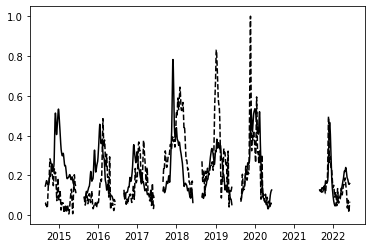

In [41]:

for test_season in [2014, 2015, 2016, 2017, 2018, 2019, 2021]:
    print(test_season)
    state_code = 'AK'
    _data = DataConstructorState(test_season = test_season, interp = True, country=country, state_code=state_code, full_year=False, gamma = gamma, window_size = 54, teacher_forcing=True, n_queries = n_op-1)
    x_train, y_train, x_test, y_test = _data()
    plt.plot(_data.test_dates, y_test[:, -1, -1], '--', color='black')
    
    state_code = 'CA'
    _data = DataConstructorState(test_season = test_season, interp = True, country=country, state_code=state_code, full_year=False, gamma = gamma, window_size = 54, teacher_forcing=True, n_queries = n_op-1)
    x_train, y_train, x_test, y_test = _data()
    plt.plot(_data.test_dates, y_test[:, -1, -1], '-', color='black')
plt.show()

2018
2019
2020
2021


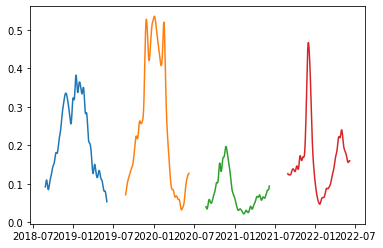

In [36]:
for test_season in [2018, 2019, 2020, 2021]:
    print(test_season)
    _data = DataConstructorState(test_season = test_season, interp = True, country=country, state_code=state_code, full_year=False, gamma = gamma, window_size = 54, teacher_forcing=True, n_queries = n_op-1)
    x_train, y_train, x_test, y_test = _data()
    plt.plot(_data.test_dates, y_test[:, -1, -1])
plt.show()

In [42]:
state_codes = ['CA','AK','AL','AR','AZ','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA',
               'ME','MD','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA',
               'RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

In [43]:
for state_code in state_codes:
    print(state_code)
    for test_season in [2014, 2015, 2016, 2017, 2018, 2019, 2021]:
        _data = DataConstructorState(test_season = test_season, interp = True, country=country, state_code=state_code, full_year=False, gamma = gamma, window_size = 54, teacher_forcing=True, n_queries = n_op-1)
        x_train, y_train, x_test, y_test = _data()

        keep_train = np.logical_not(np.isnan(x_train.mean(-1).mean(-1)))
        keep_test = np.logical_not(np.isnan(x_test.mean(-1).mean(-1)))

        x_train = x_train[keep_train]
        y_train = y_train[keep_train]
        x_test = x_test[keep_test]
        y_test = y_test[keep_test]

        x_train = tf.cast(x_train, tf.float32)[:,:,-n_op:]
        y_train = tf.cast(y_train, tf.float32)[:,:,-n_op:]
        x_test = tf.cast(x_test, tf.float32)[:,:,-n_op:]
        y_test = tf.cast(y_test, tf.float32)[:,:,-n_op:]

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


        def loss_fn(y, p_y):
            return -p_y.log_prob(y)

        epochs = 50
        optimizer = tf.optimizers.Adam(learning_rate=10**lr_power)

le
        # spent ages trying to speed up training, project = 0 and speedy_training = False is best.
        new_model = True
        if new_model:
            _model = IRNN_Bayes(kl_power=kl_power, 
                                n_op=n_op,
                                op_scale_pwr=op_scale_pwr,
                                p_scale_pwr=p_scale_pwr,
                                q_scale_pwr=q_scale_pwr,
                                rnn_units = rnn_units, 
                                gamma=gamma,       
                                window_size=54, 
                                project=0, 
                                lag = lag,
                                n_samples=prediction_steps,
                                )

        pred = _model(x_test)
        _model, history = fit(_model, 
                                train_dataset,
                                optimizer=optimizer, 
                                epochs = epochs, 
                                loss_fn = loss_fn,  
                                prediction_steps = prediction_steps,
                                speedy_training=False
                                )

        num=1

        y_pred = _model.predict(x_test, 25, verbose=True)
        dates = _data.test_dates
        true_all = y_test[:]

        mean_all = y_pred[0]
        std_all = y_pred[1]
        data_all = y_pred[2]['data']
        model_all = y_pred[2]['model']

        new_dates =  {2015: pd.date_range(dt.date(2015, 10, 19), dt.date(2016,5, 14)),
                    2016: pd.date_range(dt.date(2016, 10, 17), dt.date(2017,5, 13)),
                    2017: pd.date_range(dt.date(2017, 10, 18), dt.date(2018,5, 12)),
                    2018: pd.date_range(dt.date(2017, 10, 20), dt.date(2018,5, 11))}
        date_mask = [date in new_dates[test_season] for date in _data.test_dates]



        for g in range(28):
            true = _data.ili_scaler.inverse_transform(true_all[:, g, -1:]).squeeze()
            mean = _data.ili_scaler.inverse_transform(mean_all[:, g, -1:]).squeeze()
            std = _data.ili_scaler.inverse_transform((mean_all+std_all)[:, g, -1:]).squeeze() - mean
            data = _data.ili_scaler.inverse_transform((mean_all+data_all)[:, g, -1:]).squeeze() - mean
            model = _data.ili_scaler.inverse_transform((mean_all+model_all)[:, g, -1:]).squeeze() - mean

            df = pd.DataFrame(columns = ['True', 'Pred', 'Std', 'Data', 'Model'], 
                                data = np.asarray([true, mean, std, data, model]).T)
            if g in [6,13,20,27]:
                plt.subplot(2,2,int((g+1)/7))
                plt.plot(dates, true, color='black',label="$\gamma = $" + str(g+1))
                plt.plot(dates, mean,color='red')
                print(Metrics.skill(df))
                # for n in [0.67, 1.96]:
                for n in [1]:
                    plt.fill_between(dates,
                                    mean+n*std,
                                    mean-n*std,
                                    color='red',
                                    linewidth=0,
                                    alpha=0.3)
                    plt.plot(dates, mean+n*data, color='blue', linewidth=1, alpha=0.5, label = '$\sigma_d$')
                    plt.plot(dates, mean-n*data, color='blue', linewidth=1, alpha=0.5)
                    plt.plot(dates, mean+n*model, color='green', linewidth=1, alpha=0.5, label = '$\sigma_m$')
                    plt.plot(dates, mean-n*model, color='green', linewidth=1, alpha=0.5)
                plt.legend()
                # plt.ylim([0.5,4])
                plt.tight_layout()
                df.to_csv('Results/state2/' + country+'_'+state_code+'_'+str(num)+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + str(g+1) + 'days_ahead'+'.csv')
        #         plt.savefig('Results/' + country+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + '.pdf')
        plt.show()

CA
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


Epoch 50: 100%|██████████| 42/42 [00:25<00:00,  1.64batch/s, kl=0.237, nll=-2.25]


KeyError: 2014

In [ ]:


for g in range(28):
    true = _data.ili_scaler.inverse_transform(true_all[:, g, -1:]).squeeze()
    mean = _data.ili_scaler.inverse_transform(mean_all[:, g, -1:]).squeeze()
    std = _data.ili_scaler.inverse_transform((mean_all+std_all)[:, g, -1:]).squeeze() - mean
    data = _data.ili_scaler.inverse_transform((mean_all+data_all)[:, g, -1:]).squeeze() - mean
    model = _data.ili_scaler.inverse_transform((mean_all+model_all)[:, g, -1:]).squeeze() - mean

    df = pd.DataFrame(columns = ['True', 'Pred', 'Std', 'Data', 'Model'], 
                        data = np.asarray([true, mean, std, data, model]).T)
    if g in [6,13,20,27]:
        plt.subplot(2,2,int((g+1)/7))
        plt.plot(dates, true, color='black',label="$\gamma = $" + str(g+1))
        plt.plot(dates, mean,color='red')
        print(Metrics.skill(df))
        # for n in [0.67, 1.96]:
        for n in [1]:
            plt.fill_between(dates,
                            mean+n*std,
                            mean-n*std,
                            color='red',
                            linewidth=0,
                            alpha=0.3)
            plt.plot(dates, mean+n*data, color='blue', linewidth=1, alpha=0.5, label = '$\sigma_d$')
            plt.plot(dates, mean-n*data, color='blue', linewidth=1, alpha=0.5)
            plt.plot(dates, mean+n*model, color='green', linewidth=1, alpha=0.5, label = '$\sigma_m$')
            plt.plot(dates, mean-n*model, color='green', linewidth=1, alpha=0.5)
        plt.legend()
        # plt.ylim([0.5,4])
        plt.tight_layout()
        df.to_csv('Results/state2/' + country+'_'+state_code+'_'+str(num)+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + str(g+1) + 'days_ahead'+'.csv')
#         plt.savefig('Results/' + country+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + '.pdf')
plt.show()

In [ ]:
# y_pred = _model.predict(x_train[-365:], 25, verbose=True)
# dates = _data.train_dates[-365:]
# true_all = y_train[-365:]
num=0

y_pred = _model.predict(x_test, 25, verbose=True)
dates = _data.test_dates
true_all = y_test[:]

mean_all = y_pred[0]
std_all = y_pred[1]
data_all = y_pred[2]['data']
model_all = y_pred[2]['model']

new_dates =  {2015: pd.date_range(dt.date(2015, 10, 19), dt.date(2016,5, 14)),
            2016: pd.date_range(dt.date(2016, 10, 17), dt.date(2017,5, 13)),
            2017: pd.date_range(dt.date(2017, 10, 18), dt.date(2018,5, 12)),
            2018: pd.date_range(dt.date(2017, 10, 20), dt.date(2018,5, 11))}
date_mask = [date in new_dates[test_season] for date in _data.test_dates]



for g in range(28):
    true = _data.ili_scaler.inverse_transform(true_all[:, g, -1:]).squeeze()
    mean = _data.ili_scaler.inverse_transform(mean_all[:, g, -1:]).squeeze()
    std = _data.ili_scaler.inverse_transform((mean_all+std_all)[:, g, -1:]).squeeze() - mean
    data = _data.ili_scaler.inverse_transform((mean_all+data_all)[:, g, -1:]).squeeze() - mean
    model = _data.ili_scaler.inverse_transform((mean_all+model_all)[:, g, -1:]).squeeze() - mean

    df = pd.DataFrame(columns = ['True', 'Pred', 'Std', 'Data', 'Model'], 
                        data = np.asarray([true, mean, std, data, model]).T)
    if g in [6,13,20,27]:
        plt.subplot(2,2,int((g+1)/7))
        plt.plot(dates, true, color='black',label="$\gamma = $" + str(g+1))
        plt.plot(dates, mean,color='red')
        print(Metrics.skill(df))
        # for n in [0.67, 1.96]:
        for n in [1]:
            plt.fill_between(dates,
                            mean+n*std,
                            mean-n*std,
                            color='red',
                            linewidth=0,
                            alpha=0.3)
            plt.plot(dates, mean+n*data, color='blue', linewidth=1, alpha=0.5, label = '$\sigma_d$')
            plt.plot(dates, mean-n*data, color='blue', linewidth=1, alpha=0.5)
            plt.plot(dates, mean+n*model, color='green', linewidth=1, alpha=0.5, label = '$\sigma_m$')
            plt.plot(dates, mean-n*model, color='green', linewidth=1, alpha=0.5)
        plt.legend()
        # plt.ylim([0.5,4])
        plt.tight_layout()
        df.to_csv('Results/state2/' + country+'_'+state_code+'_'+str(num)+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + str(g+1) + 'days_ahead'+'.csv')
#         plt.savefig('Results/' + country+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + '.pdf')
plt.show()

In [ ]:
Metrics.mae(df)

In [ ]:
while True:
    for state_code in state_codes:
        try:
            for num in range(25):
                for test_season in [2015, 2016, 2017, 2018]:
                    try:
                        _data = DataConstructor(test_season = test_season, country=country, state_code=state_code, full_year=False, gamma = gamma, window_size = 54, teacher_forcing=True, n_queries = n_op-1)
                        x_train, y_train, x_test, y_test = _data()
                        
                        keep_train = np.logical_not(np.isnan(x_train.mean(-1).mean(-1)))
                        keep_test = np.logical_not(np.isnan(x_test.mean(-1).mean(-1)))

                        x_train = x_train[keep_train]
                        y_train = y_train[keep_train]
                        x_test = x_test[keep_test]
                        y_test = y_test[keep_test]

                        x_train = tf.cast(x_train, tf.float32)[:,:,-n_op:]
                        y_train = tf.cast(y_train, tf.float32)[:,:,-n_op:]
                        x_test = tf.cast(x_test, tf.float32)[:,:,-n_op:]
                        y_test = tf.cast(y_test, tf.float32)[:,:,-n_op:]

                        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
                        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

                        def loss_fn(y, p_y):
                            return -p_y.log_prob(y)

                        optimizer = tf.optimizers.Adam(learning_rate=10**lr_power)

                        n_samples = 3
                        prediction_steps = 5

                        # spent ages trying to speed up training, project = 0 and speedy_training = False is best.
                        _model = IRNN_Bayes(kl_power=kl_power, 
                                            n_op=n_op,
                                            op_scale_pwr=op_scale_pwr,
                                            p_scale_pwr=p_scale_pwr,
                                            q_scale_pwr=q_scale_pwr,
                                            rnn_units = rnn_units, 
                                            gamma=gamma,       
                                            window_size=54, 
                                            project=0, 
                                            lag = lag,
                                            n_samples=prediction_steps,
                                            )

                        pred = _model(x_test)
                        _model, history = fit(_model, 
                                                train_dataset,
                                                optimizer=optimizer, 
                                                epochs = epochs, 
                                                loss_fn = loss_fn,  
                                                prediction_steps = prediction_steps,
                                                speedy_training=False
                                                )


                        y_pred = _model.predict(x_test, 25, verbose=True)

                        mean_all = y_pred[0]
                        std_all = y_pred[1]
                        data_all = y_pred[2]['data']
                        model_all = y_pred[2]['model']

                        new_dates =  {2015: pd.date_range(dt.date(2015, 10, 19), dt.date(2016,5, 14)),
                                    2016: pd.date_range(dt.date(2016, 10, 17), dt.date(2017,5, 13)),
                                    2017: pd.date_range(dt.date(2017, 10, 18), dt.date(2018,5, 12)),
                                    2018: pd.date_range(dt.date(2017, 10, 20), dt.date(2018,5, 11))}
                        date_mask = [date in new_dates[test_season] for date in _data.test_dates]

                        for g in range(28):
                            true = _data.ili_scaler.inverse_transform(y_test[:, g, -1:]).squeeze()
                            mean = _data.ili_scaler.inverse_transform(mean_all[:, g, -1:]).squeeze()
                            std = _data.ili_scaler.inverse_transform((mean_all+std_all)[:, g, -1:]).squeeze() - mean
                            data = _data.ili_scaler.inverse_transform((mean_all+data_all)[:, g, -1:]).squeeze() - mean
                            model = _data.ili_scaler.inverse_transform((mean_all+model_all)[:, g, -1:]).squeeze() - mean

                            df = pd.DataFrame(columns = ['True', 'Pred', 'Std', 'Data', 'Model'], 
                                                data = np.asarray([true, mean, std, data, model]).T)
                            df.to_csv('Results/state/' + country+'_'+state_code+'_'+str(num)+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + str(g+1) + 'days_ahead'+'.csv')

                            if g in [6,13,20,27]:
                                plt.subplot(2,2,int((g+1)/7))
                                plt.plot(_data.test_dates, true, color='black',label="$\gamma = $" + str(g+1))
                                plt.plot(_data.test_dates, mean,color='red')
                                print(Metrics.skill(df))
                                # for n in [0.67, 1.96]:
                                for n in [1]:
                                    plt.fill_between(_data.test_dates,
                                                    mean+n*std,
                                                    mean-n*std,
                                                    color='red',
                                                    linewidth=0,
                                                    alpha=0.3)
                                    plt.plot(_data.test_dates, mean+n*data, color='blue', linewidth=1, alpha=0.5, label = '$\sigma_d$')
                                    plt.plot(_data.test_dates, mean-n*data, color='blue', linewidth=1, alpha=0.5)
                                    plt.plot(_data.test_dates, mean+n*model, color='green', linewidth=1, alpha=0.5, label = '$\sigma_m$')
                                    plt.plot(_data.test_dates, mean-n*model, color='green', linewidth=1, alpha=0.5)
                                plt.legend()
                                # plt.ylim([0.5,4])
                                plt.tight_layout()
                                # plt.savefig('Results/' + country+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + '.pdf')
                        plt.clf()
                    except:
                        pass

                    y_pred = _model.predict(x_train[-365:], 25, verbose=True)

                    mean_all = y_pred[0]
                    std_all = y_pred[1]
                    data_all = y_pred[2]['data']
                    model_all = y_pred[2]['model']

                    new_dates =  {2015: pd.date_range(dt.date(2015, 10, 19), dt.date(2016,5, 14)),
                                2016: pd.date_range(dt.date(2016, 10, 17), dt.date(2017,5, 13)),
                                2017: pd.date_range(dt.date(2017, 10, 18), dt.date(2018,5, 12)),
                                2018: pd.date_range(dt.date(2017, 10, 20), dt.date(2018,5, 11))}
                    date_mask = [date in new_dates[test_season] for date in _data.test_dates]

                    for g in range(28):
                        true = _data.ili_scaler.inverse_transform(y_train[-365:, g, -1:]).squeeze()
                        mean = _data.ili_scaler.inverse_transform(mean_all[:, g, -1:]).squeeze()
                        std = _data.ili_scaler.inverse_transform((mean_all+std_all)[:, g, -1:]).squeeze() - mean
                        data = _data.ili_scaler.inverse_transform((mean_all+data_all)[:, g, -1:]).squeeze() - mean
                        model = _data.ili_scaler.inverse_transform((mean_all+model_all)[:, g, -1:]).squeeze() - mean

                        df = pd.DataFrame(columns = ['True', 'Pred', 'Std', 'Data', 'Model'], 
                                            data = np.asarray([true, mean, std, data, model]).T)
                        # df.to_csv('Results/' + country+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + str(g+1) + 'days_ahead'+'.csv')

                        if g in [6,13,20,27]:
                            plt.subplot(2,2,int((g+1)/7))
                            plt.plot(_data.train_dates[-365:], true, color='black',label="$\gamma = $" + str(g+1))
                            plt.plot(_data.train_dates[-365:], mean,color='red')
                            print(Metrics.skill(df))
                            # for n in [0.67, 1.96]:
                            for n in [1]:
                                plt.fill_between(_data.train_dates[-365:],
                                                mean+n*std,
                                                mean-n*std,
                                                color='red',
                                                linewidth=0,
                                                alpha=0.3)
                                plt.plot(_data.train_dates[-365:], mean+n*data, color='blue', linewidth=1, alpha=0.5, label = '$\sigma_d$')
                                plt.plot(_data.train_dates[-365:], mean-n*data, color='blue', linewidth=1, alpha=0.5)
                                plt.plot(_data.train_dates[-365:], mean+n*model, color='green', linewidth=1, alpha=0.5, label = '$\sigma_m$')
                                plt.plot(_data.train_dates[-365:], mean-n*model, color='green', linewidth=1, alpha=0.5)
                            plt.legend()
                            # plt.ylim([0.5,4])
                            plt.tight_layout()
                            # plt.savefig('Results/' + country+'_Forecasts_'+str(test_season) + '-' + str(test_season-1999) + '.pdf')
                    plt.clf()
        except:
            pass

